# NYC 311 Customer Service Requests Analysis

__Objective:__
Explore data collected by NYC 311 non emergency services. Understand high level trends and inspect response times for different complaint types & locations. 

__Data Overview:__
NYC311 receives thousands of requests related to several hundred types of non-emergency services, including noise complaints, plumbing issues, and illegally parked cars. 

__Contents:__
1. Explore & inspect the data
2. Treat missing values
3. Vizualize
    - complaint types volume and closing time distribution
    - City Wise Complaints and closing time distribution
    - Category wise complaint by City

4. Inference Tests
    - ANOVA test to check difference in response time by complaint types
    - Chi-Sq test of independence to check relation between location & complaint type

<__Modelling:__ Maybe, predict response times in minutes?>

__Acknowledgements:__
- Detailed data can be found at [Kaggle](https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis)
- This analysis was inspired by Kaggle User Riya Patel ([Notebook](https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis))


In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()
os.chdir('Datasets')

In [3]:
df = pd.read_csv('NYC311data.csv')

C:\Users\parora19\AppData\Local\Temp\ipykernel_19312\2779644800.py:1: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NYC311data.csv')


In [4]:
# df.info()
df.head(1).transpose()

,0
Unique Key,32310363
Created Date,12/31/2015 11:59:45 PM
Closed Date,01-01-16 0:55
Agency,NYPD
Agency Name,New York City Police Department
Complaint Type,Noise - Street/Sidewalk
Descriptor,Loud Music/Party
Location Type,Street/Sidewalk
Incident Zip,10034.0
Incident Address,71 VERMILYEA AVENUE


## Null value Treatment

In [5]:
df.rename(columns = {'Resolution Action Updated Date': 'update_date'
                     , 'Closed Date':'closed_date'
                     , 'Created Date':'created_date'}, inplace=True)

#Making all strings lower case
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

print("before: ", df.shape)

#Remove columns with more than 85% missing values
missing_cols = (df.isnull().sum()/df.shape[0]).where(lambda x: x>0.85).dropna().index.tolist()
df.drop(columns = missing_cols, inplace=True, axis=1)

print("before: ", df.shape)

before:  (300698, 53)
before:  (300698, 39)


In [6]:
#How many rows have at least 1 NA value? 18% of the data
df.isnull().any(axis=1).sum()/df.shape[0]

#Dropping less useful columns with several missing values
df.drop(columns = ['Incident Address', 'Street Name', 'Cross Street 1', 
                   'Cross Street 2', 'X Coordinate (State Plane)',
                  'Y Coordinate (State Plane)'], inplace=True)

df.isnull().sum().where(lambda x: x>100).dropna()

closed_date      2164.0
Descriptor       5914.0
Location Type     131.0
Incident Zip     2615.0
Address Type     2815.0
City             2614.0
Facility Type    2171.0
update_date      2187.0
Latitude         3540.0
Longitude        3540.0
Location         3540.0
dtype: float64

In [7]:
# Are all 3540 lat, long, location and coordinates missing together?
df.loc[df['Incident Zip'].isna(), ['Incident Zip', 'City', 'Latitude', 'Longitude', 'Location']].isna().sum()

# Lat, long, location, city and zipa are almost always missing together

Incident Zip    2615
City            2611
Latitude        2574
Longitude       2574
Location        2574
dtype: int64

### Filling NAs

In [8]:
# Most common cityBrooklyn
city = df.City.mode()[0]

#Most common Zipcode in Brooklyn
zipc = df.loc[df.City == city, 'Incident Zip'].mode()[0]

#Most common location at the zipcode
loca = df.loc[df['Incident Zip'] == zipc, 'Location'].mode()[0]

#Extracting lat & long from most common location
print(loca)
loca = loca.replace('(', '')
loca = loca.replace(')', '')
lat, long = pd.to_numeric(loca.split(','))
print(lat, long)

(40.70865242217872, -73.95406586999786)
40.70865242217872 -73.95406586999786


In [9]:
df['City'].fillna(city, inplace=True)
df['Incident Zip'].fillna(zipc, inplace=True)
df['Latitude'].fillna(lat, inplace=True)
df['Longitude'].fillna(long, inplace=True)
df['Location'].fillna(loca, inplace=True)

#How many rows have at least 1 NA value? 3%
print('% rows with missing data:', round(df.isnull().any(axis=1).sum()/df.shape[0], 2))

df.isnull().sum().where(lambda x: x>100).dropna()

% rows with missing data: 0.03


closed_date      2164.0
Descriptor       5914.0
Location Type     131.0
Address Type     2815.0
Facility Type    2171.0
update_date      2187.0
dtype: float64

In [10]:
#How often are Resolution date and closing data missing together? Almost always. I will use these to fill each other 
df.loc[df['closed_date'].isna(), ['update_date', 'closed_date']].isna().sum()

#when closed Date is missing
df.loc[df.closed_date.isna(), 'closed_date'] = df.loc[df.closed_date.isna(), 'update_date']

#When update_date is missing
df.loc[df.update_date.isna(), 'update_date'] = df.loc[df.update_date.isna(), 'closed_date']

In [11]:
#Facility type is always Precinct
df['Facility Type'].value_counts()
df['Facility Type'].fillna('Precinct', inplace=True)

df.isnull().sum().where(lambda x: x>100).dropna()

closed_date      2148.0
Descriptor       5914.0
Location Type     131.0
Address Type     2815.0
update_date      2148.0
dtype: float64

#### Filling NAs with most common values in respective group

In [23]:
# Filling missing descriptor with most common issue in respective zipcode

# Dictionary of Most common issue by zipcode

temp1 = df[['Incident Zip', 'Descriptor']].groupby('Incident Zip').apply(pd.DataFrame.mode).reset_index(drop=True)
temp1.dropna(how='any', inplace=True)
temp2 = temp1.set_index('Incident Zip').to_dict('index')

df.loc[df.Descriptor.isna(), ['Descriptor']] = df.loc[df.Descriptor.isna(), ['Incident Zip']].\
    apply(lambda x: temp2.get(x[0]).get('Descriptor') if temp2.get(x[0]) != None else None, axis=1)

In [14]:
#Removing 2k odd rows with still missing values
df.dropna(how='any', inplace=True)
df.isna().sum()

Unique Key                0
created_date              0
closed_date               0
Agency                    0
Agency Name               0
Complaint Type            0
Descriptor                0
Location Type             0
Incident Zip              0
Address Type              0
City                      0
Facility Type             0
Status                    0
Due Date                  0
Resolution Description    0
update_date               0
Community Board           0
Borough                   0
Park Facility Name        0
Park Borough              0
School Name               0
School Number             0
School Region             0
School Code               0
School Phone Number       0
School Address            0
School City               0
School State              0
School Zip                0
School Not Found          0
Latitude                  0
Longitude                 0
Location                  0
dtype: int64

### Converting to lower case

In [24]:
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

In [16]:
#Converting dates
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['created_date'] = pd.to_datetime(df['created_date'])

#Close time in hours 
df['daystoclose'] = (df.closed_date - df.created_date).dt.days
df['hourstoclose'] = (df.closed_date - df.created_date).dt.seconds/3600

In [17]:
summ = df.groupby(df.created_date.dt.strftime('%Y-%m')).agg(
    daystoclose = ('daystoclose', 'mean'),
    hourstoclose = ('hourstoclose', 'mean'),
    cases = ('Unique Key', 'count')
)
summ.reset_index(inplace=True)
summ

,created_date,daystoclose,hourstoclose,cases
0,2015-03,0.009792,3.563186,2451
1,2015-04,0.009710,3.453281,27086
2,2015-05,0.012061,3.635764,35985
3,2015-06,0.010156,3.891294,35054
4,2015-07,0.009554,3.975226,34227
5,2015-08,0.010586,4.082789,34667
6,2015-09,0.015933,4.112948,35084
7,2015-10,0.024304,4.051393,32340
8,2015-11,0.023413,4.021972,30538
9,2015-12,0.029518,4.066171,30287


### Dual Axis chart

Text(0.5, 1.0, 'Closing time Vs case volume')

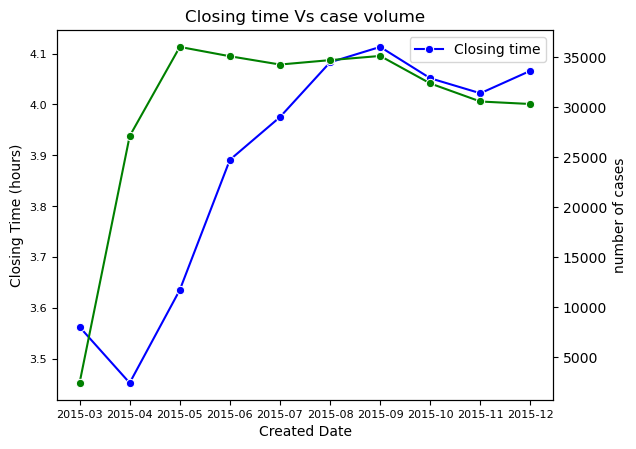

In [24]:
sns.lineplot(data = summ, x='created_date', y='hourstoclose', marker='o', color='b')
plt.legend(labels = ['Closing time', 'Case Volume'])
plt.xlabel('Created Date')
plt.ylabel('Closing Time (hours)')
plt.tick_params(axis='both', which='major', labelsize=8)

ax2 = plt.twinx()
sns.lineplot(data=summ, x='created_date', y='cases', marker='o', color='g')

plt.xlabel('Created Date')
plt.ylabel('number of cases')
plt.title('Closing time Vs case volume')

#Add legend

__Observation:__ closing time increasing with case volume. Although that is to be expected

### Subplots / Side-by-side plot

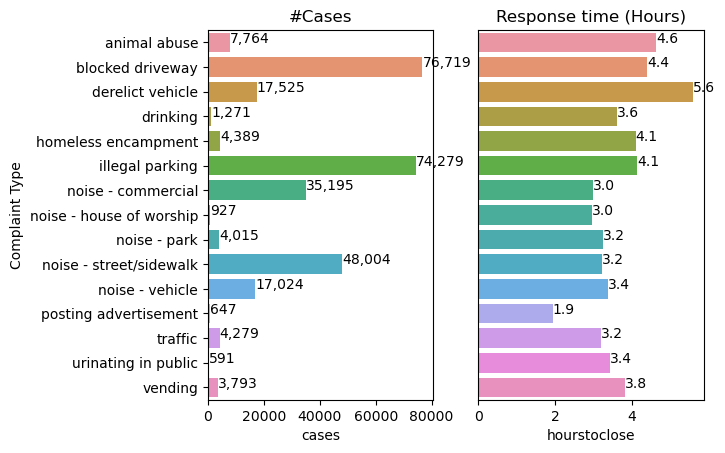

In [116]:
#Closing time by complaint types
summ = df.groupby('Complaint Type').agg(
    hourstoclose = ('hourstoclose', 'mean'),
    cases = ('Unique Key', 'count')
).where(lambda x: x['cases']>500).dropna().reset_index()

fig, ax = plt.subplots(ncols=2)

#First plot
ax0 = sns.barplot(data=summ, y='Complaint Type', x='cases', label = 'cases', ax=ax[0])
# ax[0].set_xlim([None, 30000])
#Adding Data Labels
for x, y in zip(summ['cases'], summ.index):
    ax0.text(x=x,
             y=y,
            s='{:,.0f}'.format(x))
ax0.title.set_text('#Cases')
#Second Plot
ax1 = sns.barplot(data=summ, y='Complaint Type', x='hourstoclose', ax=ax[1])

for x, y in zip(summ['hourstoclose'], summ.index):
    ax1.text(x=x,
             y=y,
            s='{:,.1f}'.format(x))
# ax[1].set_xlim([2, None])
#Removing y axis from second plot to reduce clutter
ax[1].get_yaxis().set_visible(False)
ax1.title.set_text('Response time (Hours)')


__Observations:__
- Derelict vehicle has low colume but high response time
- posting advertisement has smallest volume but fastest response time

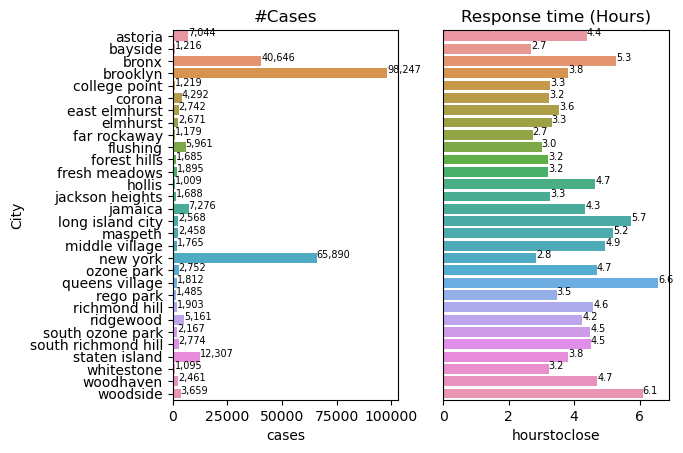

In [130]:
#Closing time by complaint types
summ = df.groupby('City').agg(
    hourstoclose = ('hourstoclose', 'mean'),
    cases = ('Unique Key', 'count')
).where(lambda x: x['cases']>1000).dropna().reset_index()

summ
fig, ax = plt.subplots(ncols=2)

#First plot
ax0 = sns.barplot(data=summ, y='City', x='cases', label = 'cases', ax=ax[0])
# ax[0].set_xlim([None, 30000])
#Adding Data Labels
for x, y in zip(summ['cases'], summ.index):
    ax0.text(x=x,
             y=y,
            s='{:,.0f}'.format(x),
            size=7)
ax0.title.set_text('#Cases')
#Second Plot
ax1 = sns.barplot(data=summ, y='City', x='hourstoclose', ax=ax[1])

for x, y in zip(summ['hourstoclose'], summ.index):
    ax1.text(x=x,
             y=y,
            s='{:,.1f}'.format(x),
            size=7)
# ax[1].set_xlim([2, None])
#Removing y axis from second plot to reduce clutter
ax[1].get_yaxis().set_visible(False)
ax1.title.set_text('Response time (Hours)')


__Observations:__
- New York has most cases and best response time
- Queens Village has slowest response time and also the lowest cases

#### Category wise complaint by City

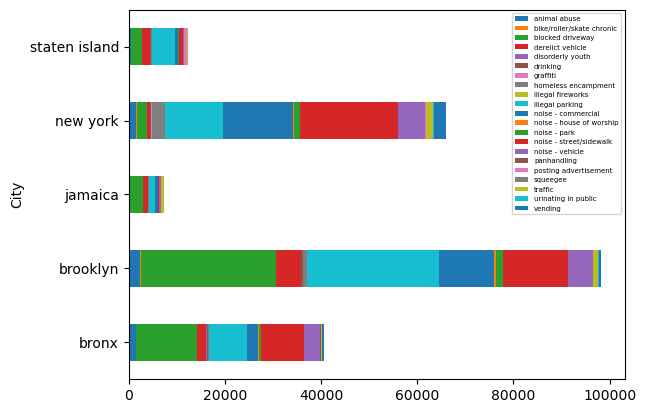

In [50]:
top5cities = df.City.value_counts().head(5)
subs = df[df.City.isin(top5cities.index)]
subs2 = pd.crosstab(subs.City, subs['Complaint Type'])

subs2.plot(kind = 'barh', stacked = True)
plt.legend(loc='upper right', fontsize=5)

__Observations:__ There are some popular issues specific to each city
- Illegal parking is a common complainst across all cities
- In New York City, noise-street is most common complaint
- In Jamaica & Bronx, blcoked driveway is most common complaint
- Brooklyn also has several illegal parking complaints

### Chi-Square test of independence
Are the type of complaint or service requested and location related?

In [21]:
from scipy.stats import chi2_contingency

df_ct = pd.crosstab(df['Complaint Type'], df.City)
stat, p, dof, expected = chi2_contingency(df_ct)
print('Chi-Square Statistic Value: ',stat)
print('p value: ',p)
print('degrees of freedom: ',dof)

Chi-Square Statistic Value:  109536.40425261823
p value:  0.0
degrees of freedom:  940


__Observation:__
As we have seen from stacked bar chart above, complaint type and city are not independent

### ANOVA test to check difference in mean response time across different location types
Assumptions  of ANOVA test:
1. <ins>Observations within and accross groups are independent:</ins> This is mostly true for complaints except in locations such as "House of Worship" or "Club" where same noise complaint could be made by many people
2. <ins>Data within each group is nearly normal:</ins> As can be seen response times are positively skewed
3. <ins>Variability accross groups is nearly equal:</ins> Not sure how to check this?


In [169]:
# closed by Location Type
summ = df.groupby('Complaint Type').agg(
    obs = ('closed_flag', 'count'),
    avgclosetime = ('hourstoclose', 'mean'),
    stdev = ('hourstoclose', 'std')
)

summ.loc[summ.obs>100, ['obs', 'avgclosetime', 'stdev']].\
    sort_values(by = 'obs', ascending = False)

,obs,avgclosetime,stdev
Complaint Type,,,
Blocked Driveway,77044,4.384702,3.985412
Illegal Parking,75361,4.143077,3.925986
Noise - Street/Sidewalk,48612,3.221578,3.318570
Noise - Commercial,35577,2.991226,3.058270
Derelict Vehicle,17718,5.588838,5.195639
Noise - Vehicle,17083,3.376230,3.380510
Animal Abuse,7778,4.626220,4.253091
Traffic,4498,3.197791,3.507195
Homeless Encampment,4416,4.099266,3.919552


<AxesSubplot:xlabel='hourstoclose', ylabel='Complaint Type'>

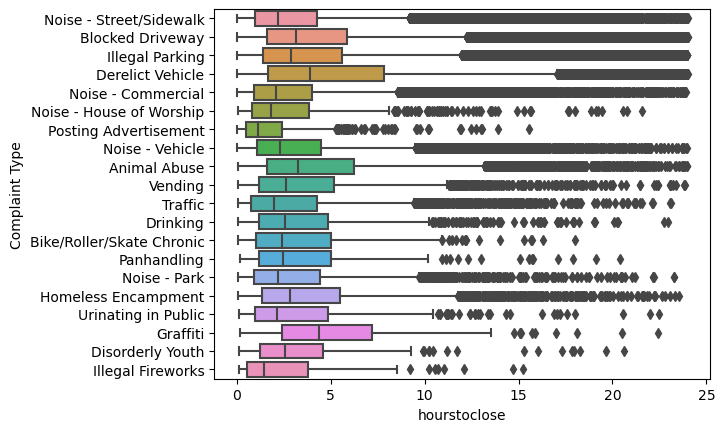

In [194]:
import seaborn as sns

ls=summ[summ.obs>100].index.tolist()

sns.boxplot(x='hourstoclose', y='Complaint Type', data=df.loc[df['Complaint Type'].isin(ls),:])


### Conducting ANOVA test

In [239]:
# Removing nulls for ANOVA test
df2 = df.loc[~df['hourstoclose'].isna(), :].copy()
ls=summ[summ.obs>100].index.tolist()

#Splitting hourstoclose by complaint types
for i in range(len(ls)): 
    exec("c{} = df2.loc[df['Complaint Type'] == '{}', 'hourstoclose']".format(i, ls[i]))

In [241]:
import scipy.stats as stats
fscore, pval = stats.f_oneway(c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19)
print(fscore, pval)

513.3014564063392 0.0


__Result__: At F-Statistic of 513, The probablity of Average response time being different for any of the Complaint type group is negligible